In [ ]:
!pip install geopandas
!pip install geojson
!pip install rasterio
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 36.4 MB/s 
     |████████████████████████████████| 6.3 MB 26.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 5.0 MB/s 


In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 182 kB/s 
     |████████████████████████████████| 4.1 MB 25.6 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 
     |████████████████████████████████| 10.1 MB 53.4 MB/s 
     |████████████████████████████████| 466 kB 56.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


In [ ]:
from os import path as op
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv
from scipy import ndimage

import pickle
import rasterio
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import itertools
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
import torch.nn.functional as F 

from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
import torchvision
import torchvision.transforms as transforms
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler
from functools import partial

In [ ]:
 %load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/data')

In [ ]:
import sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/src')

In [ ]:
from CNN_Train_Validate import *
import CNN_Train_Validate

In [ ]:
X = np.load('X.npy')

In [ ]:
X[0].shape

(13, 256, 256)

In [ ]:
y = np.load('y.npy')

In [ ]:
y[0].shape

(1, 256, 256)

In [ ]:
classes = ['Agriculture', 'Bares_and_Built', 'Bogs', 'Forest', 'Grassland','Shrub/Heathland','Water']
labels=[0,1,2,3,4,5,6]

In [ ]:
train_data,test_data = create_train_test_split(X,y,test_size=0.3,random_state=42,gpu=True)


In [ ]:
def test_statistics(test_true,test_predictions,verbose=True):

    '''
    This functions calculates accuracy,balanced_accuracy,f1,recall, and precision.
    input: test_true - the real predicted test values taken from the whole test dataloader,
           test_predictions - predicted values on the whole test dataloader.
    output: results for the statistics
    '''
     
    # the number of samples in our test loader
    n_test = len(list(test_true))

    # calculate the statistics
    bal_acc = balanced_accuracy_score(test_true,test_predictions)
    
    recall = recall_score(test_true,test_predictions,average='weighted')

    precision = precision_score(test_true,test_predictions,average='weighted')

    f1 = f1_score(test_true,test_predictions,average='weighted')
    
    accuracy = accuracy_score(test_true,test_predictions)


    
    if verbose==True:

        print(f'Accuracy:{accuracy}')
        print(f'Balanced Accuracy:{bal_acc}')
        print(f'Recall:{recall}')
        print(f'Precision:{precision}')
        print(f'f1 score:{f1}')


    return bal_acc,recall,precision,f1,accuracy

In [ ]:
def mask_trainings_and_predictions_equal_polygons(x_train,y_train,model):

 '''
   Input: batch from our training dataset and our model.
   Output: modified y_train and modified predictions.
   
   Description: We work with sparse labels so most of the pixels in the elements of y_batch
                will be nodata (less than 0 ). We don't want our loss to take them into account,
                so we need to create a mask which restricts the domain of the loss function
                only on the non-negative pixel values of the elements from y_batch. In this fun-
                ction we also consider each polygon to be equally important, no matter how small
                it is.

  '''
# record the batch size
 batch_size = y_train.shape[0]

  # we find the predictions
 y_pred  = model(x_train)

 # copy(clone) y_train
 y_train_copy = y_train.clone()

# we create the desired mask and apply it to y_train
 mask_train = (y_train >= 0)
 y_train_masked = y_train[mask_train]

 # we reshape it by removing a band ( band 1 )
 y_train_copy = y_train_copy.reshape(batch_size,256,256)

 # we merge the labels from each batch to one long image
 y_train_copy = y_train_copy.reshape(256*batch_size,256).T

 # -999 -> 0, -1->0, 0->500. 
 mask_999 = (y_train_copy==-999)
 mask_0 = (y_train_copy==0)
 mask_1 = (y_train_copy==-1)

 y_train_copy[mask_999]=0
 y_train_copy[mask_1]=0
 y_train_copy[mask_0]=500

 # we will need this structure for the following function
 s = ndimage.generate_binary_structure(2,2)

 # this is our polygons id mask
 
 polygons_id_mask = ndimage.label(y_train_copy.cpu(),structure=s)[0]
 polygons_id_mask = torch.LongTensor(polygons_id_mask.T)
 polygons_id_mask = polygons_id_mask.view(batch_size,1,256,256)

 # we use the mask_train to take only the non nan valus
 polygons_id_mask_masked = polygons_id_mask[mask_train]

 # we reshape our mask ( remove 1 dimension )
 mask_train = mask_train.reshape([len(x_train),256,256])

# this is our masked y_pred
 y_pred = torch.cat([y_pred[:,0,:,:][mask_train],  y_pred[:,1,:,:][mask_train],y_pred[:,2,:,:][mask_train],y_pred[:,3,:,:][mask_train],
           y_pred[:,4,:,:][mask_train],y_pred[:,5,:,:][mask_train], y_pred[:,6,:,:][mask_train]],dim=0)
  
                      
  # we fix y_pred to the appropriate shape
 y_pred = torch.transpose(y_pred.view(7,-1),0,1)

 # we take the indexes of the sorted polygons_id_mask_masked
 sorted_indexes_polygons_id_mask_masked = polygons_id_mask_masked.argsort()

 # we sort y_train, y_pred, and polygons_id_mask_masked based on the above indexes
 y_train_masked_sorted = y_train_masked[sorted_indexes_polygons_id_mask_masked]
 sorted_polygons_id_mask_masked = polygons_id_mask_masked[sorted_indexes_polygons_id_mask_masked]
 y_pred_masked_sorted = y_pred[sorted_indexes_polygons_id_mask_masked]


 # now we divide our y_train and y_pred into subsets for every polygon
 y_train_masked_split_by_polygons = np.split(y_train_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])
 y_pred_masked_split_by_polygons = np.split(y_pred_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])

 return y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons

In [ ]:
def calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons):

    '''
    This function takes two input arguments: y_train_masked_split_by_polygons and
    y_pred_masked_split_by_polygons, which denote our y_train labels per pixel but
    grouped also per polygon. That is how we give equal importance to each polygon
    when training.
    Output cross_entropy_loss as average of the losses for the number of polygons
    '''
    number_of_polygons = len(y_pred_masked_split_by_polygons)
    acc_loss = 0 # the accumulated loss based on the polygons
    criterion = nn.CrossEntropyLoss()
    for y_t,y_p in zip(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons):
        
        acc_loss+=criterion(y_p,y_t)
        
    return acc_loss/number_of_polygons

In [ ]:
def cross_validate_dl_model_check(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=45,augment=True):

    '''
    This function takes a deep learnin model, as well ass X and y data. It initiates
    a cross validated training of the model and outputs an average balanced accuracy,
    precision, recall, f1, and confusion matrix with respect to the different folds.
    '''

    results_bal_acc = []
    results_prec=[]
    results_recall=[]
    results_f1=[]
    results_cm = []

    # Our split
    np.random.seed(seed)
    kf = KFold(n_splits=folds,shuffle=True)
    kf.get_n_splits(X)


    for train_index, test_index in kf.split(X): # loop through the indices of the different folds

        # Create the X_train,X_test,y_train,y_test split
        #X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]

        print(np.array(test_index).mean())
        np.random.seed(54)
        
       # if len(np.unique(y_train))!=len(np.unique(y_test)):
          #print('ERROR')
          #return 'ERROR'
        
        # Put them to gpu
        #X_train = torch.FloatTensor(X_train).cuda()
        #y_train = torch.LongTensor(y_train).cuda()

        #X_test = torch.FloatTensor(X_test).cuda()
        #y_test = torch.LongTensor(y_test).cuda()

        # Prepare the training set for batch sampling
        #train_data = list(zip(X_train,y_train))

        # Prepare the testing set for batch sampling
        #test_data = list(zip(X_test,y_test))

        ## augment our training data
        if augment == True:
            # Here we make augmentations
            # First we need to make the size of the samples for each class to be approximately equal
            # take classes 2,5,6 -> Bogs, Shrub/Heathland, because these 2 classes confuse each other
            # and also they are the only classes that we have poor performance on
            klas_2 = CNN_Train_Validate.select_class(train_data,2)
            klas_5 = CNN_Train_Validate.select_class(train_data,5)

            torch.use_deterministic_algorithms(False)
            klas_2_augm = CNN_Train_Validate.augment_dataset(klas_2,2)
            klas_5_augm = CNN_Train_Validate.augment_dataset(klas_5,2)

            # add the augmented datasets to our train set
            train_data+=klas_2_augm+klas_5_augm

        # we train our. model
        #model,test_true,test_predictions,cm = train_validate_model(train_data=train_data, test_data=test_data, labels=labels, classes=classes, 
                                                 #init_features=init_features, epochs = epochs, batch_size=batch_size, init_lr=init_lr)
                                                
        # calculate the balanced accuracy 
        #bal_acc,recall,precision,f1 = CNN_Train_Validate.test_statistics(test_true,test_predictions,verbose=True)

        # append them to our lists
        #results_bal_acc.append(bal_acc)
        #results_prec.append(precision)
        #results_recall.append(recall)
        #results_f1.append(f1)
        #results_cm.append(cm)
          

    #return results_bal_acc,results_prec,results_recall,results_f1,results_cm

In [ ]:
def cross_validate_dl_model(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=False,augment=True):

    '''
    This function takes a deep learnin model, as well ass X and y data. It initiates
    a cross validated training of the model and outputs an average balanced accuracy,
    precision, recall, f1, and confusion matrix with respect to the different folds.
    '''

    results_bal_acc = []
    results_prec=[]
    results_recall=[]
    results_f1=[]
    results_cm = []
    results_acc=[]

    # Our split
    if seed!=False:  
      np.random.seed(seed)

    kf = KFold(n_splits=folds,shuffle=True)
    kf.get_n_splits(X)


    for train_index, test_index in kf.split(X): # loop through the indices of the different folds

        # Create the X_train,X_test,y_train,y_test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        if len(np.unique(y_train))!=len(np.unique(y_test)):
          print('ERROR')
          return 'ERROR'
        
        # Put them to gpu
        X_train = torch.FloatTensor(X_train).cuda()
        y_train = torch.LongTensor(y_train).cuda()

        X_test = torch.FloatTensor(X_test).cuda()
        y_test = torch.LongTensor(y_test).cuda()

        # Prepare the training set for batch sampling
        train_data = list(zip(X_train,y_train))

        # Prepare the testing set for batch sampling
        test_data = list(zip(X_test,y_test))

        ## augment our training data
        if augment == True:
            # Here we make augmentations
            # First we need to make the size of the samples for each class to be approximately equal
            # take classes 2,5,6 -> Bogs, Shrub/Heathland, because these 2 classes confuse each other
            # and also they are the only classes that we have poor performance on
            klas_2 = CNN_Train_Validate.select_class(train_data,2)
            klas_5 = CNN_Train_Validate.select_class(train_data,5)

            torch.use_deterministic_algorithms(False)
            klas_2_augm = CNN_Train_Validate.augment_dataset(klas_2,2)
            klas_5_augm = CNN_Train_Validate.augment_dataset(klas_5,2)

            # add the augmented datasets to our train set
            train_data+=klas_2_augm+klas_5_augm

        # we train our. model
        model,test_true,test_predictions,cm = train_validate_model(train_data=train_data, test_data=test_data, labels=labels, classes=classes, 
                                                 init_features=init_features, epochs = epochs, batch_size=batch_size, init_lr=init_lr)
                                                
        # calculate the balanced accuracy 
        acc,bal_acc,recall,precision,f1 = test_statistics(test_true,test_predictions,verbose=True)

        # append them to our lists
        results_bal_acc.append(bal_acc)
        results_prec.append(precision)
        results_recall.append(recall)
        results_f1.append(f1)
        results_cm.append(cm)
        results_acc.append(acc)
          

    return results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm

In [ ]:
!pip install AdaBound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import adabound


In [ ]:
def train_validate_model(train_data,test_data,labels,classes,input_model = False,init_features=32,batch_size=16,epochs=20,init_lr=0.001,verbose=True,gpu=True):
    
    '''
    Function that trains our neural network
    input: train and test data, labels=[0,1,2,3,...],classes=['Agriculture',..] 
           init_features, batch_size, number of epochs,
           and gpu = True/False - whether we use gpu or not
           init_lr - initial learning rate

    output: our trained model, all true classes from the whole test set, and all
            predicted classes from the test set
    '''
    np.random.seed(3407)
    torch.manual_seed(3407)
    torch.use_deterministic_algorithms(True)
    
    # trackers for printing
    train_losses=[]
    val_losses=[]
    Epochs = list(torch.arange(epochs))

    # we check for input model
    if input_model==False:  
      
      # instatiate our model
      if gpu == True:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features).cuda()
      else:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features)
    
    else:
      model = input_model

    # creating our train and test loaders
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_data,batch_size=45,shuffle=False)

    # setting our loss function and our optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(),lr = init_lr)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience = 10,factor = 0.1,verbose=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,40)

    for i in range(epochs):
        i+=1
        
       ########## TRAINING ########
        for batch,(x_train_batch,y_train_batch) in enumerate(train_loader):
            batch+=1

            # apply mask on our y_train_batch and y_pred_batch 
            y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons = mask_trainings_and_predictions_equal_polygons(x_train_batch,y_train_batch,model)
        
            # calculate the loss for the current batch
            train_loss=calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons)
            
            optimizer.zero_grad() # optimizing
            train_loss.backward()       # back propagation
            optimizer.step()      # step update
        
        # update the scheduler
        scheduler.step()

        # update the train losses
        train_losses.append(train_loss)

        if verbose == True:
            print(f"Epoch:{i}, train_loss:{train_loss}, {optimizer.param_groups[0]['lr']}")

        ######## VALIDATION ######

        # if we are in the last epoch
        if i == epochs-1:
          
          test_predictions=[] # we will append here the predictions from 
                              # y_pred_batch from each test batch
                            
          test_true = [] # we will append here the y_test_batch from each
                         # test batch

        for batch,(x_test_batch,y_test_batch) in enumerate(test_loader):

            with torch.no_grad():
                 
                 # apply mask on our y_train_batch and y_pred_batch 
                y_test_batch,y_pred_batch = CNN_Train_Validate.mask_trainings_and_predictions(x_test_batch,y_test_batch,model)
            
            if i == epochs-1:
              # generate batch predictions from y_pred_batch
              batch_predictions = CNN_Train_Validate.nn_generate_predictions(y_pred_batch)
              test_predictions+=batch_predictions

              # append the results for 
              test_true+=list(y_test_batch.cpu().detach().numpy())
            
            # calculate the loss for the current batch
            val_loss=criterion(y_pred_batch,y_test_batch)  

        # Update the val losses
        val_losses.append(val_loss)

        # Adjust the learning rate based on the validation loss
        #scheduler.step(val_loss)
        
        if verbose == True:
            print(f"Epoch:{i}, val_loss:{val_loss}, {optimizer.param_groups[0]['lr']}")

    print(' ')
    print(f'init features: {init_features}, batch size: {batch_size}, learning rate: {init_lr}')

    ####################### PLOTTING #############################

    # plot a confusion matrix
    cm = confusion_matrix(test_true,test_predictions,labels=labels)
    CNN_Train_Validate.plot_cm(cm,classes)


    # Plot train and validation losses
    train_losses = [item.cpu().detach() for item in train_losses]
    val_losses = [item.cpu().detach() for item in val_losses]
    plt.title('TRAIN AND VALIDATION LOSSES')
    plt.plot(Epochs,train_losses,label='train_loss',color='blue')
    plt.plot(Epochs,val_losses,label='val_loss',color='red')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model,test_true,test_predictions,cm 

In [ ]:
model,test_true,test_predictions  = train_validate_model(train_data,test_data,labels,classes,init_features=32,epochs=100,batch_size = 4,init_lr=1e-3);

In [ ]:
test_statistics(test_true,test_predictions,verbose=True);

Balanced Accuracy:0.8281247286026625
Recall:0.8891658467257024
Precision:0.8936641050547758
f1 score:0.8890081743042128


In [ ]:
torch.save(model.state_dict(),'Second_Best.net')

#MANUAL TRAINING

In [ ]:
model,test_true,test_predictions  = train_validate_model(train_data,test_data,labels,classes,input_model=model,init_features=64,epochs=40,batch_size = 4,init_lr=1e-4);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_statistics(test_true,test_predictions,verbose=True);

# KFold


In [ ]:
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_cm = []
mean_accuracy=[]

In [ ]:
loops=5
init_features = 32
epochs = 100
init_lr = 1e-3
batch_size = 16

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
for i in range(50,54):
    print(i)
    cross_validate_dl_model_check(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=i,augment=False)
    print(' ')

42
203.2340425531915
213.9787234042553
214.31428571428572
 
43
212.95035460992906
195.82269503546098
222.81428571428572
 
44
219.5035460992908
208.9290780141844
203.0142857142857
 
45
217.33333333333334
211.12765957446808
202.9857142857143
 


Epoch:1, train_loss:1.2514855861663818, 0.000998458666866564
Epoch:1, val_loss:1.3143845796585083, 0.000998458666866564
Epoch:2, train_loss:0.8867096304893494, 0.0009938441702975688
Epoch:2, val_loss:1.0393487215042114, 0.0009938441702975688
Epoch:3, train_loss:1.0350170135498047, 0.0009861849601988384
Epoch:3, val_loss:0.9175007343292236, 0.0009861849601988384
Epoch:4, train_loss:0.6032674312591553, 0.0009755282581475768
Epoch:4, val_loss:0.8594963550567627, 0.0009755282581475768
Epoch:5, train_loss:0.6880354285240173, 0.0009619397662556434
Epoch:5, val_loss:0.8023120164871216, 0.0009619397662556434
Epoch:6, train_loss:0.7571942806243896, 0.0009455032620941839
Epoch:6, val_loss:0.8766234517097473, 0.0009455032620941839
Epoch:7, train_loss:0.867499589920044, 0.0009263200821770461
Epoch:7, val_loss:0.861135721206665, 0.0009263200821770461
Epoch:8, train_loss:0.46226614713668823, 0.0009045084971874737
Epoch:8, val_loss:0.9523303508758545, 0.0009045084971874737
Epoch:9, train_loss:0.68787

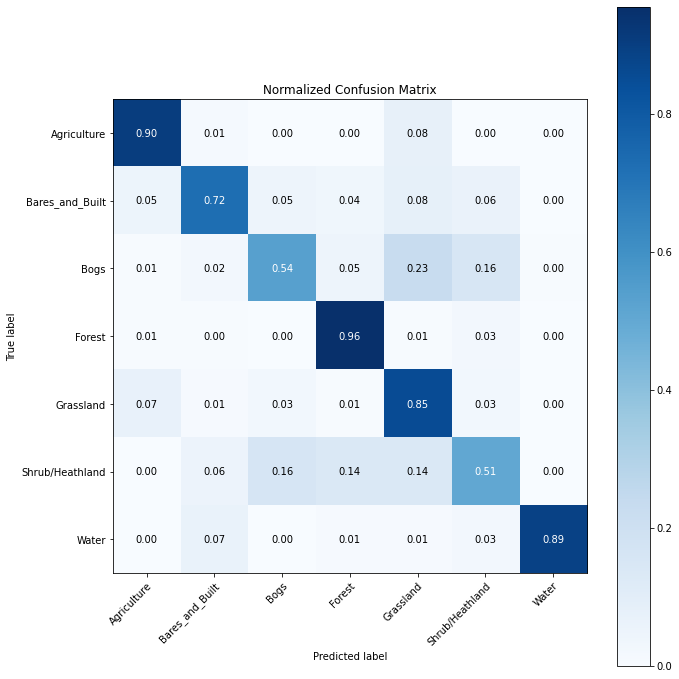

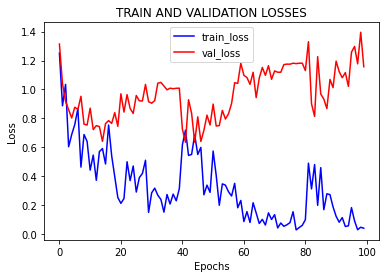

Accuracy:0.8428066663943466
Balanced Accuracy:0.7667823974715197
Recall:0.8428066663943466
Precision:0.8439989307040174
f1 score:0.8417853593773691
Epoch:1, train_loss:1.1175737380981445, 0.000998458666866564
Epoch:1, val_loss:1.3590943813323975, 0.000998458666866564
Epoch:2, train_loss:0.8488873243331909, 0.0009938441702975688
Epoch:2, val_loss:1.1051796674728394, 0.0009938441702975688
Epoch:3, train_loss:0.9360367059707642, 0.0009861849601988384
Epoch:3, val_loss:0.9704402685165405, 0.0009861849601988384
Epoch:4, train_loss:0.7515755891799927, 0.0009755282581475768
Epoch:4, val_loss:0.8341508507728577, 0.0009755282581475768
Epoch:5, train_loss:0.7967764735221863, 0.0009619397662556434
Epoch:5, val_loss:0.8702352643013, 0.0009619397662556434
Epoch:6, train_loss:0.8139054775238037, 0.0009455032620941839
Epoch:6, val_loss:0.8140511512756348, 0.0009455032620941839
Epoch:7, train_loss:0.6703699231147766, 0.0009263200821770461
Epoch:7, val_loss:0.8725436925888062, 0.0009263200821770461
Epo

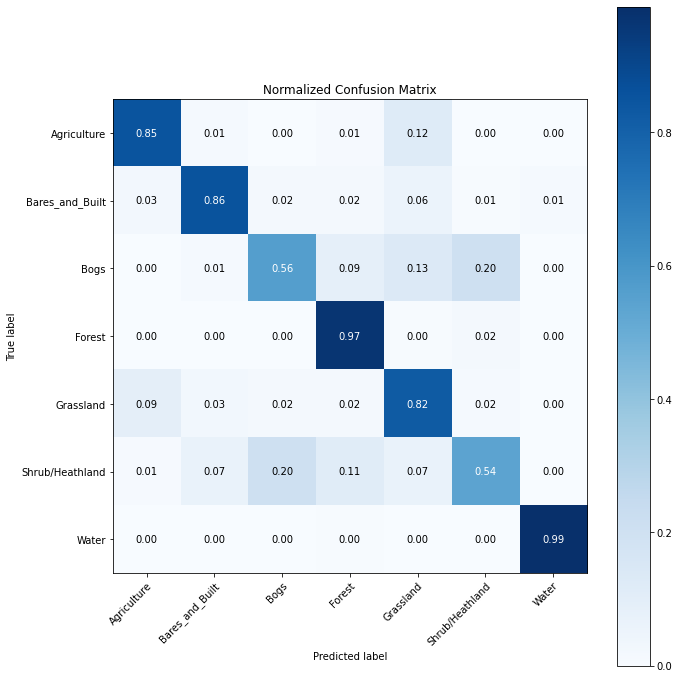

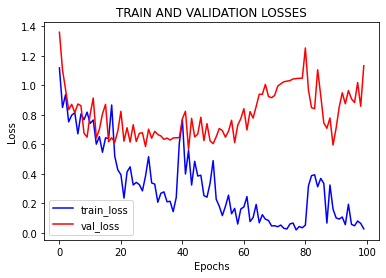

Accuracy:0.8573457127252867
Balanced Accuracy:0.7986875323965673
Recall:0.8573457127252867
Precision:0.858537082229021
f1 score:0.8562968724961737
Epoch:1, train_loss:1.2464232444763184, 0.000998458666866564
Epoch:1, val_loss:1.0821739435195923, 0.000998458666866564
Epoch:2, train_loss:0.9050430655479431, 0.0009938441702975688
Epoch:2, val_loss:0.8281790614128113, 0.0009938441702975688
Epoch:3, train_loss:0.913585901260376, 0.0009861849601988384
Epoch:3, val_loss:0.8348128199577332, 0.0009861849601988384
Epoch:4, train_loss:0.8519769906997681, 0.0009755282581475768
Epoch:4, val_loss:0.7265105843544006, 0.0009755282581475768
Epoch:5, train_loss:0.9008913636207581, 0.0009619397662556434
Epoch:5, val_loss:0.6582401990890503, 0.0009619397662556434
Epoch:6, train_loss:0.4196513593196869, 0.0009455032620941839
Epoch:6, val_loss:0.7100902199745178, 0.0009455032620941839
Epoch:7, train_loss:0.732104480266571, 0.0009263200821770461
Epoch:7, val_loss:0.564311683177948, 0.0009263200821770461
Epoc

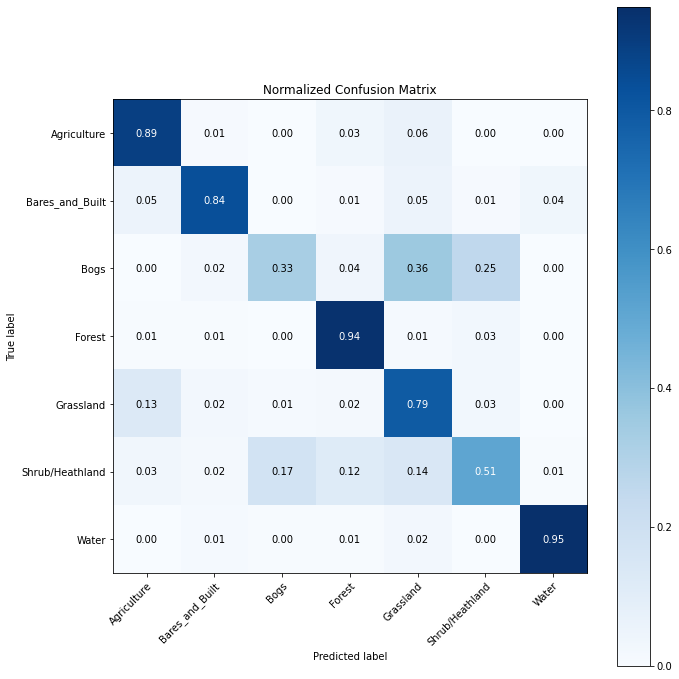

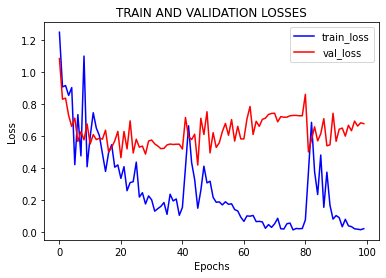

Accuracy:0.8362808468807671
Balanced Accuracy:0.7489595150655142
Recall:0.8362808468807671
Precision:0.8323489313566591
f1 score:0.8321743450137676
Epoch:1, train_loss:1.1793431043624878, 0.000998458666866564
Epoch:1, val_loss:1.161452293395996, 0.000998458666866564
Epoch:2, train_loss:1.1543898582458496, 0.0009938441702975688
Epoch:2, val_loss:1.0018759965896606, 0.0009938441702975688
Epoch:3, train_loss:0.8077846169471741, 0.0009861849601988384
Epoch:3, val_loss:0.7582583427429199, 0.0009861849601988384
Epoch:4, train_loss:0.8072717785835266, 0.0009755282581475768
Epoch:4, val_loss:0.8433264493942261, 0.0009755282581475768
Epoch:5, train_loss:0.9021730422973633, 0.0009619397662556434
Epoch:5, val_loss:0.6757816076278687, 0.0009619397662556434
Epoch:6, train_loss:0.8841215372085571, 0.0009455032620941839
Epoch:6, val_loss:0.7245496511459351, 0.0009455032620941839
Epoch:7, train_loss:0.6435999870300293, 0.0009263200821770461
Epoch:7, val_loss:0.5869040489196777, 0.0009263200821770461
E

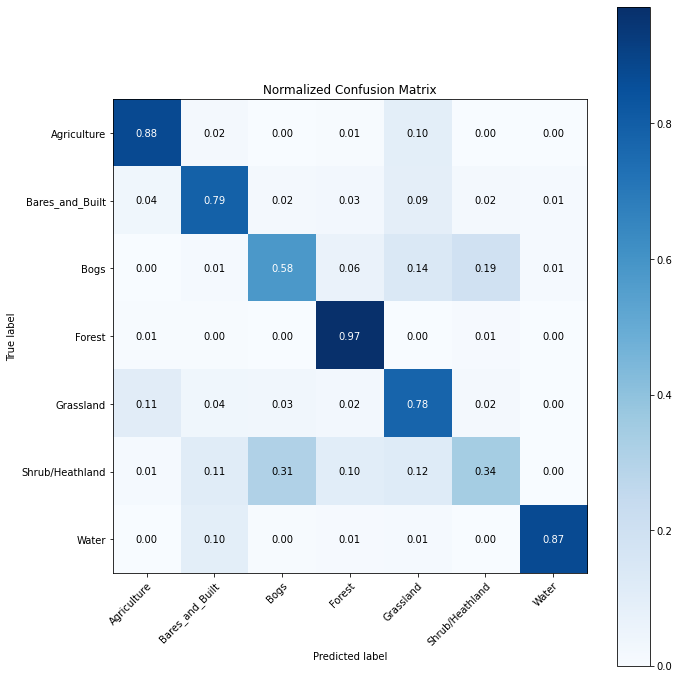

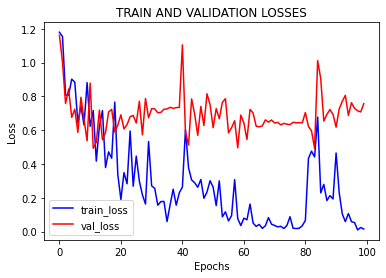

Accuracy:0.8143553745579252
Balanced Accuracy:0.7440086948772004
Recall:0.8143553745579252
Precision:0.8271610875445077
f1 score:0.8118421796798807
Epoch:1, train_loss:1.3236043453216553, 0.000998458666866564
Epoch:1, val_loss:1.3271408081054688, 0.000998458666866564
Epoch:2, train_loss:1.1408133506774902, 0.0009938441702975688
Epoch:2, val_loss:1.0159605741500854, 0.0009938441702975688
Epoch:3, train_loss:0.9648375511169434, 0.0009861849601988384
Epoch:3, val_loss:1.0564721822738647, 0.0009861849601988384
Epoch:4, train_loss:0.7811333537101746, 0.0009755282581475768
Epoch:4, val_loss:0.8627711534500122, 0.0009755282581475768
Epoch:5, train_loss:0.8895565867424011, 0.0009619397662556434
Epoch:5, val_loss:0.8987387418746948, 0.0009619397662556434
Epoch:6, train_loss:1.1561681032180786, 0.0009455032620941839
Epoch:6, val_loss:0.7891368865966797, 0.0009455032620941839
Epoch:7, train_loss:1.0839492082595825, 0.0009263200821770461
Epoch:7, val_loss:0.8295608162879944, 0.0009263200821770461


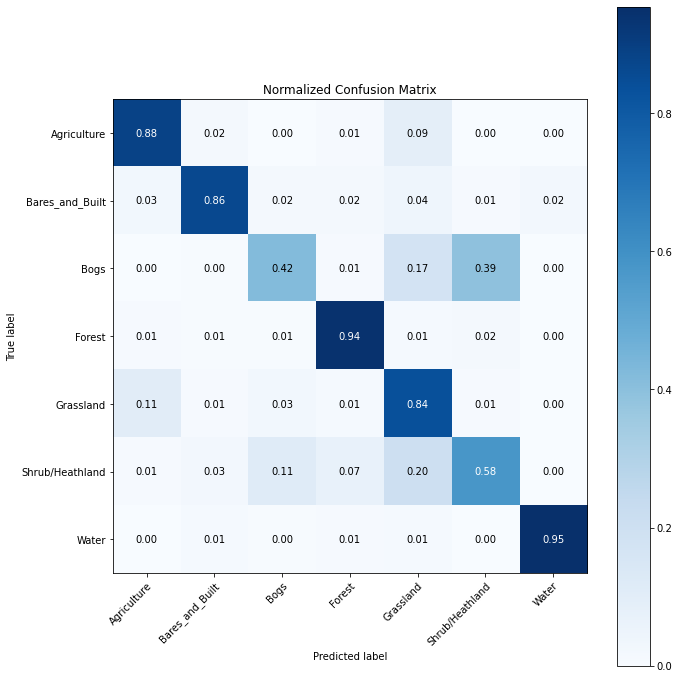

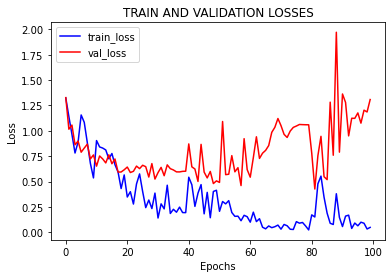

Accuracy:0.8562952151288235
Balanced Accuracy:0.7819101571220911
Recall:0.8562952151288235
Precision:0.857240825822542
f1 score:0.8558121807080646
Epoch:1, train_loss:1.380200982093811, 0.000998458666866564
Epoch:1, val_loss:1.0676867961883545, 0.000998458666866564
Epoch:2, train_loss:0.9448239803314209, 0.0009938441702975688
Epoch:2, val_loss:0.8595365285873413, 0.0009938441702975688
Epoch:3, train_loss:1.0613139867782593, 0.0009861849601988384
Epoch:3, val_loss:0.7364743947982788, 0.0009861849601988384
Epoch:4, train_loss:0.9117199182510376, 0.0009755282581475768
Epoch:4, val_loss:0.6693608164787292, 0.0009755282581475768
Epoch:5, train_loss:0.9528787136077881, 0.0009619397662556434
Epoch:5, val_loss:0.6386256814002991, 0.0009619397662556434
Epoch:6, train_loss:0.8179354071617126, 0.0009455032620941839
Epoch:6, val_loss:0.7524170279502869, 0.0009455032620941839
Epoch:7, train_loss:0.6540062427520752, 0.0009263200821770461
Epoch:7, val_loss:0.4991053342819214, 0.0009263200821770461
Ep

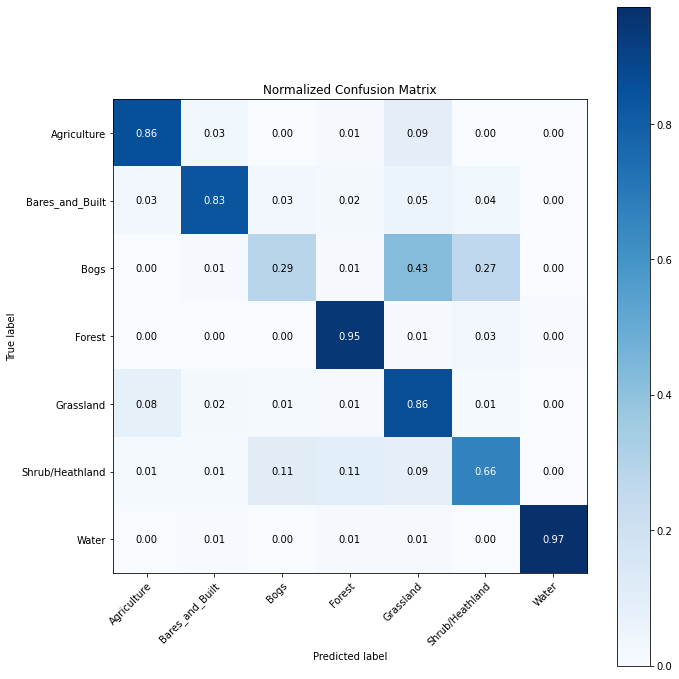

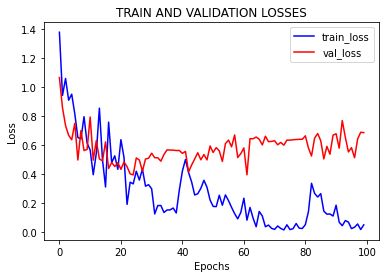

Accuracy:0.8588936248224025
Balanced Accuracy:0.7742503767879947
Recall:0.8588936248224025
Precision:0.8567080587342126
f1 score:0.8556434631101751
Epoch:1, train_loss:1.300155758857727, 0.000998458666866564
Epoch:1, val_loss:0.9172704219818115, 0.000998458666866564
Epoch:2, train_loss:1.0917688608169556, 0.0009938441702975688
Epoch:2, val_loss:0.7270817160606384, 0.0009938441702975688
Epoch:3, train_loss:0.938249945640564, 0.0009861849601988384
Epoch:3, val_loss:0.6403536796569824, 0.0009861849601988384
Epoch:4, train_loss:0.7095715999603271, 0.0009755282581475768
Epoch:4, val_loss:0.531563937664032, 0.0009755282581475768
Epoch:5, train_loss:0.7988758087158203, 0.0009619397662556434
Epoch:5, val_loss:0.5432544946670532, 0.0009619397662556434
Epoch:6, train_loss:0.8928824067115784, 0.0009455032620941839
Epoch:6, val_loss:0.5302256941795349, 0.0009455032620941839
Epoch:7, train_loss:0.9186087250709534, 0.0009263200821770461
Epoch:7, val_loss:0.5299850106239319, 0.0009263200821770461
Epo

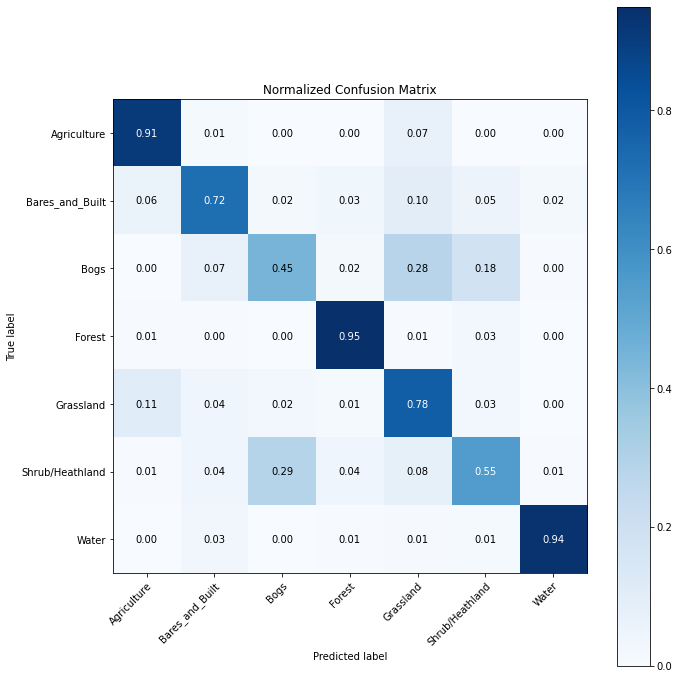

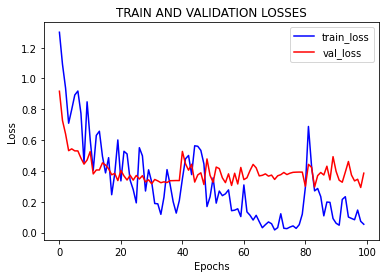

Accuracy:0.8376849957887138
Balanced Accuracy:0.7559826371529111
Recall:0.8376849957887138
Precision:0.8454170153884452
f1 score:0.8402000200333977
Epoch:1, train_loss:1.143731951713562, 0.000998458666866564
Epoch:1, val_loss:1.2424944639205933, 0.000998458666866564
Epoch:2, train_loss:0.976790726184845, 0.0009938441702975688
Epoch:2, val_loss:1.2775131464004517, 0.0009938441702975688
Epoch:3, train_loss:1.1697131395339966, 0.0009861849601988384
Epoch:3, val_loss:1.1413782835006714, 0.0009861849601988384
Epoch:4, train_loss:0.8001908659934998, 0.0009755282581475768
Epoch:4, val_loss:1.2173418998718262, 0.0009755282581475768
Epoch:5, train_loss:0.6048738956451416, 0.0009619397662556434
Epoch:5, val_loss:1.1153305768966675, 0.0009619397662556434
Epoch:6, train_loss:0.6520864367485046, 0.0009455032620941839
Epoch:6, val_loss:1.115285038948059, 0.0009455032620941839
Epoch:7, train_loss:0.9617767333984375, 0.0009263200821770461
Epoch:7, val_loss:1.0231852531433105, 0.0009263200821770461
Epo

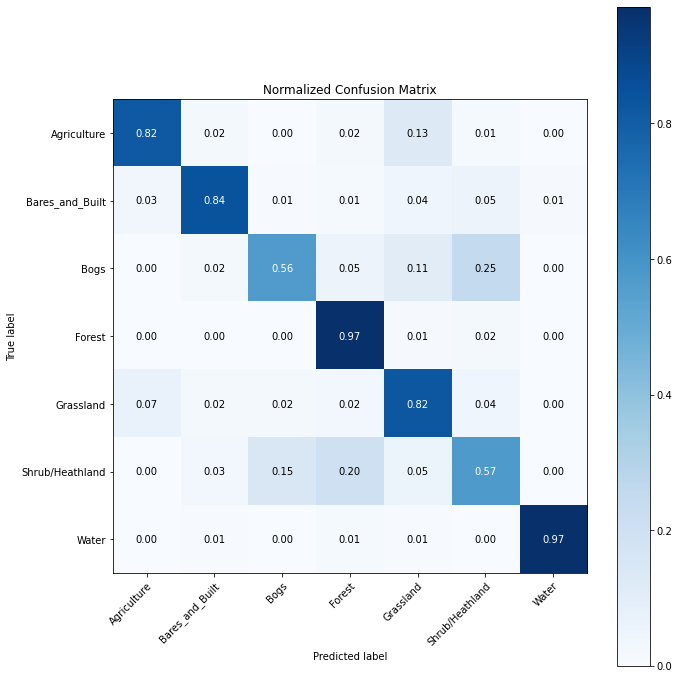

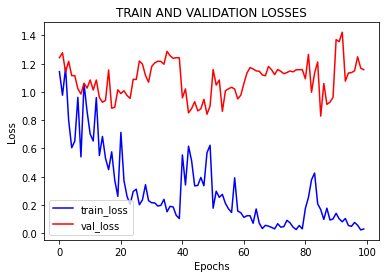

Accuracy:0.8448833183875206
Balanced Accuracy:0.7944115595598943
Recall:0.8448833183875206
Precision:0.8436967173574246
f1 score:0.8436692922742165
Epoch:1, train_loss:1.5992012023925781, 0.000998458666866564
Epoch:1, val_loss:1.5548723936080933, 0.000998458666866564
Epoch:2, train_loss:0.9392656087875366, 0.0009938441702975688
Epoch:2, val_loss:1.0293419361114502, 0.0009938441702975688
Epoch:3, train_loss:1.1296530961990356, 0.0009861849601988384
Epoch:3, val_loss:0.7850245833396912, 0.0009861849601988384
Epoch:4, train_loss:0.9618349671363831, 0.0009755282581475768
Epoch:4, val_loss:0.664106547832489, 0.0009755282581475768
Epoch:5, train_loss:0.5531427264213562, 0.0009619397662556434
Epoch:5, val_loss:1.2969259023666382, 0.0009619397662556434
Epoch:6, train_loss:0.5758107304573059, 0.0009455032620941839
Epoch:6, val_loss:0.9722937941551208, 0.0009455032620941839
Epoch:7, train_loss:0.6583613157272339, 0.0009263200821770461
Epoch:7, val_loss:0.9711888432502747, 0.0009263200821770461
E

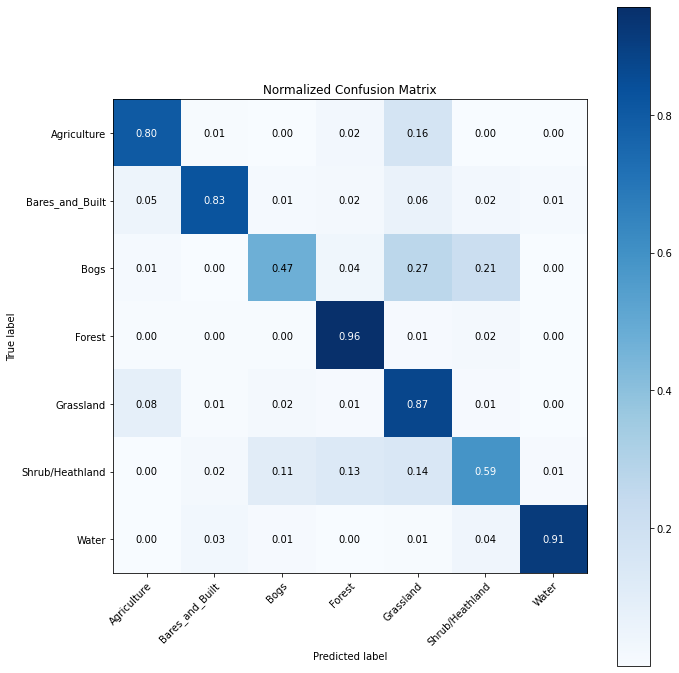

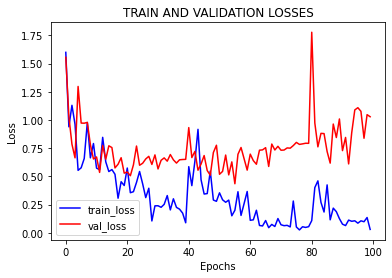

Accuracy:0.8447920920812462
Balanced Accuracy:0.776807171068176
Recall:0.8447920920812462
Precision:0.8569750246809212
f1 score:0.8460283486682377


In [ ]:
for i in range(50,53):
    
    results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = cross_validate_dl_model(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=i,augment=False)
    mean_balanced_accuracy.extend(results_bal_acc)
    mean_recall.extend(results_recall)
    mean_prec.extend(results_prec)
    mean_f1.extend(results_f1)
    mean_cm.extend(results_cm)
    mean_accuracy.extend(results_acc)

In [ ]:
mean_accuracy

In [ ]:
mean_balanced_accuracy

[0.7610257241291196,
 0.8041700421034196,
 0.7364338556274468,
 0.7459420912800022,
 0.7969808282349696,
 0.7758787052999353,
 0.7812545560772012,
 0.7934929201761516,
 0.7578450508306835,
 0.7804426185419624,
 0.7869848213701724,
 0.7893216961992433,
 0.7307530501782321,
 0.8092605005380242,
 0.7241748242947105]

In [ ]:
mean_recall

[0.8387251207943615,
 0.8520486129838376,
 0.8228318081551532,
 0.7831242608548742,
 0.8671663026934021,
 0.8447357107865191,
 0.8363627339057924,
 0.8464944173930652,
 0.8615386063498338,
 0.8370408974956799,
 0.8401158766882205,
 0.8583756731556013,
 0.817838246409675,
 0.8574614502357589,
 0.8301267353149623]

In [ ]:
mean_f1

[0.8419709815670559,
 0.8511258198811827,
 0.8172743111549415,
 0.7831671380387071,
 0.8667570584598108,
 0.8462467414045928,
 0.8343492818359681,
 0.8442388630109113,
 0.8646120597809105,
 0.8354776509898423,
 0.8378839771341182,
 0.857695615616504,
 0.8142794014564428,
 0.8547644640803393,
 0.829276896035793]

In [ ]:
mean_prec

[0.85015618385223,
 0.8519784252297733,
 0.818553012640757,
 0.7850789497480023,
 0.8682957237410399,
 0.853291454286444,
 0.835156016633697,
 0.8443233766098126,
 0.8702330710334053,
 0.8445463924189968,
 0.8385328382248983,
 0.8601114499819017,
 0.8159723866789887,
 0.8543771468029637,
 0.8358389802878813]

In [ ]:
mean_cm

[array([[24853,   307,    14,   238,  3567,    27,     1],
        [  366,  8621,   190,   278,   723,   387,    94],
        [   11,    59,  1140,   156,   743,   630,     1],
        [  215,   274,   170, 32447,   408,   645,    74],
        [ 1477,   463,   773,   254, 15569,   594,    25],
        [   43,   416,  1896,   600,  1513,  5793,    40],
        [    0,    99,     8,   261,   139,    12,  6181]]),
 array([[19617,   691,     0,   667,  3883,   216,     0],
        [  437,  9375,    45,   194,   579,   152,   106],
        [    0,    24,  2637,     7,   461,   941,     2],
        [  111,   121,    62, 29632,   216,   608,   101],
        [ 2554,   329,   227,   545, 18810,   268,    39],
        [   13,   139,   838,   813,   834,  3530,     7],
        [    0,   119,    34,    32,    39,     5, 11186]]),
 array([[13815,   229,     4,   111,  1515,    11,    36],
        [  951,  4733,    88,   118,   753,   157,    41],
        [   12,   131,  1759,   155,  2423,  1123,  

In [ ]:
len(mean_prec)

15

#Generate Map

In [ ]:
raster_image = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/data/raster_file/big.tif'
raster_subimage = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/Maps/Scotland_Subraster.tif'
raster_subimage_classifier = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/Maps/Scotland_Subraster_Classifier_Second.tif'
bands = 13
windows_height = 1024
windows_width = 1024
origin_x = 2500
origin_y = 2500

In [ ]:
CNN_Train_Validate.create_map(model,raster_image,raster_subimage,raster_subimage_classifier,
           windows_height,windows_width,origin_x,origin_y,bands,gpu=True)